In [12]:
# Set up environment and fix JSON files
import os
import json
from pathlib import Path
import shutil


def fix_json_file(json_path):
    # Read the JSON file
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # Get the directory containing the JSON file
    json_dir = os.path.dirname(json_path)
    
    # Get list of actual image files in the directory
    image_files = [f for f in os.listdir(json_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    # Create a mapping from base filenames to full filenames
    filename_map = {os.path.splitext(f)[0]: f for f in image_files}
    
    # Create a new dictionary to store the fixed data
    fixed_data = {}
    fixed_count = 0
    
    for key, value in data.items():
        if not isinstance(value, dict):
            continue
            
        # Get the original filename from the value
        original_filename = value.get('filename', '')
        
        if not original_filename:
            print(f"Warning: Missing filename in entry: {key}")
            continue
        
        # Get the base name (without extension)
        base_name = os.path.splitext(original_filename)[0]
        
        # Find the matching file in the directory
        if base_name in filename_map:
            fixed_key = filename_map[base_name]
            # Update the filename in the value
            value['filename'] = fixed_key
            fixed_data[fixed_key] = value
            fixed_count += 1
        else:
            print(f"Warning: Could not find matching file for {original_filename}")
    
    # Write the fixed data back to the file
    fixed_json_path = str(json_path).replace('.json', '_fixed.json')
    with open(fixed_json_path, 'w') as f:
        json.dump(fixed_data, f, indent=2)
    
    print(f"Fixed {fixed_count} entries in {json_path}")
    return fixed_json_path

def main():
    # Set up paths
    base_dir = Path("/root/Documents/maestria/deep_learning_2025-2/week3/Exercise_3")
    dataset_dir = base_dir / "balloon"
    
    # Fix training JSON
    train_json = dataset_dir / "train" / "via_region_data.json"
    if train_json.exists():
        print(f"Fixing training JSON: {train_json}")
        fixed_train = fix_json_file(train_json)
        print(f"Created fixed training JSON: {fixed_train}")
    else:
        print(f"Error: Training JSON not found at {train_json}")
    
    # Fix validation JSON
    val_json = dataset_dir / "val" / "via_region_data.json"
    if val_json.exists():
        print(f"\nFixing validation JSON: {val_json}")
        fixed_val = fix_json_file(val_json)
        print(f"Created fixed validation JSON: {fixed_val}")
    else:
        print(f"Error: Validation JSON not found at {val_json}")

if __name__ == "__main__":
    main()

Fixing training JSON: /root/Documents/maestria/deep_learning_2025-2/week3/Exercise_3/balloon/train/via_region_data.json
Fixed 61 entries in /root/Documents/maestria/deep_learning_2025-2/week3/Exercise_3/balloon/train/via_region_data.json
Created fixed training JSON: /root/Documents/maestria/deep_learning_2025-2/week3/Exercise_3/balloon/train/via_region_data_fixed.json

Fixing validation JSON: /root/Documents/maestria/deep_learning_2025-2/week3/Exercise_3/balloon/val/via_region_data.json
Fixed 13 entries in /root/Documents/maestria/deep_learning_2025-2/week3/Exercise_3/balloon/val/via_region_data.json
Created fixed validation JSON: /root/Documents/maestria/deep_learning_2025-2/week3/Exercise_3/balloon/val/via_region_data_fixed.json


Setting up paths and verifying directory structure...
Dataset directory already exists.

Verifying dataset structure...
Found 61 training images
Found 13 validation images

Registering datasets...
Loaded 61 images from /root/Documents/maestria/deep_learning_2025-2/week3/Exercise_3/balloon/train
Loaded 61 images from /root/Documents/maestria/deep_learning_2025-2/week3/Exercise_3/balloon/train

Number of training images: 61
Loaded 13 images from /root/Documents/maestria/deep_learning_2025-2/week3/Exercise_3/balloon/val
Number of validation images: 13

Sample training images:
Loaded 61 images from /root/Documents/maestria/deep_learning_2025-2/week3/Exercise_3/balloon/train


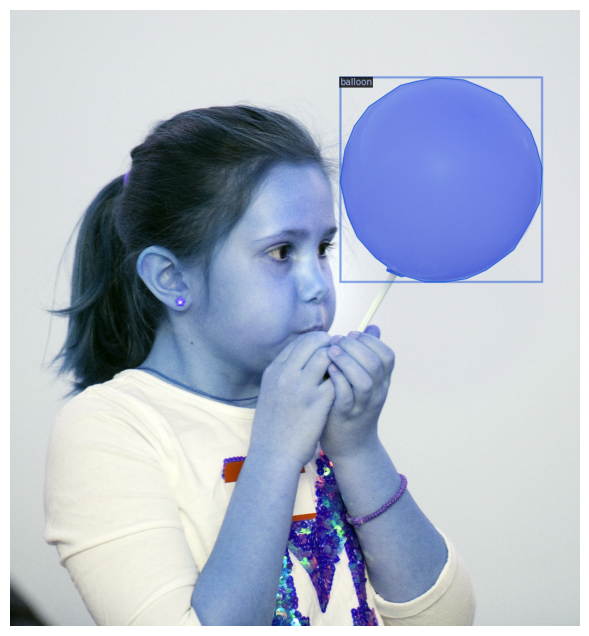

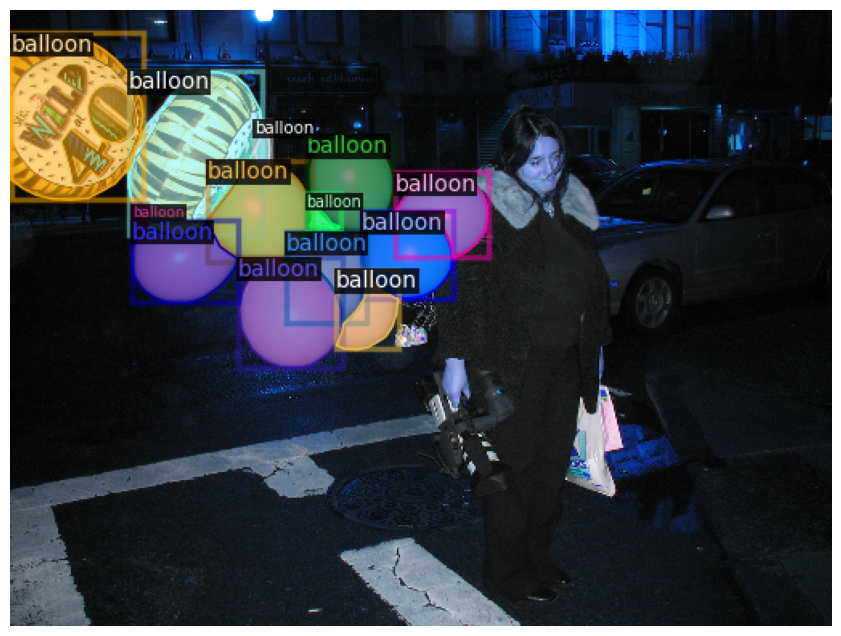

In [15]:
# Balloon Detection with Detectron2 - Complete Solution

# 1. Install Required Packages
!pip install -q torch torchvision
!pip install -q 'git+https://github.com/facebookresearch/detectron2.git'
!pip install -q opencv-python matplotlib pycocotools

# 2. Import Required Libraries
import os
import json
import random
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.logger import setup_logger
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.structures import BoxMode

# Set up logger
setup_logger()

# 3. Set up paths and verify directory structure
print("Setting up paths and verifying directory structure...")
BASE_DIR = Path("/root/Documents/maestria/deep_learning_2025-2/week3/Exercise_3")
DATASET_DIR = BASE_DIR / "balloon"
TRAIN_JSON = DATASET_DIR / "train" / "via_region_data_fixed.json"
VAL_JSON = DATASET_DIR / "val" / "via_region_data_fixed.json"
TRAIN_IMG_DIR = DATASET_DIR / "train"
VAL_IMG_DIR = DATASET_DIR / "val"
OUTPUT_DIR = BASE_DIR / "output"

# 4. Download and extract dataset if needed
if not DATASET_DIR.exists():
    print("Downloading dataset...")
    !wget -q https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip
    !unzip -q balloon_dataset.zip
    !rm balloon_dataset.zip
    print("Dataset downloaded and extracted successfully!")
else:
    print("Dataset directory already exists.")

# 5. Verify the dataset structure
print("\nVerifying dataset structure...")
def verify_dataset_structure():
    required_dirs = [TRAIN_IMG_DIR, VAL_IMG_DIR]
    required_files = [TRAIN_JSON, VAL_JSON]
    
    for dir_path in required_dirs:
        if not dir_path.exists():
            print(f"Error: Directory not found: {dir_path}")
            return False
    
    for file_path in required_files:
        if not file_path.exists():
            print(f"Error: File not found: {file_path}")
            return False
    
    # Count training and validation images
    train_images = list(TRAIN_IMG_DIR.glob("*.jpg")) + list(TRAIN_IMG_DIR.glob("*.jpeg")) + list(TRAIN_IMG_DIR.glob("*.png"))
    val_images = list(VAL_IMG_DIR.glob("*.jpg")) + list(VAL_IMG_DIR.glob("*.jpeg")) + list(VAL_IMG_DIR.glob("*.png"))
    
    print(f"Found {len(train_images)} training images")
    print(f"Found {len(val_images)} validation images")
    
    if len(train_images) == 0 or len(val_images) == 0:
        print("Error: No images found in the dataset directories")
        return False
    
    return True

if not verify_dataset_structure():
    print("\nError: Dataset structure is not correct. Please check the directory structure.")
    print("Expected structure:")
    print("balloon/")
    print("├── train/")
    print("│   ├── via_region_data.json")
    print("│   ├── image1.jpg")
    print("│   └── ...")
    print("└── val/")
    print("    ├── via_region_data.json")
    print("    ├── image1.jpg")
    print("    └── ...")
    raise SystemExit("Please fix the dataset structure and try again.")

# 6. Dataset Loading and Registration
def get_balloon_dicts(img_dir, json_file):
    """
    Parse the VIA annotation format and convert it to Detectron2's format.
    """
    # Convert to absolute paths
    img_dir = Path(img_dir).resolve()
    json_file = Path(json_file).resolve()
    
    with open(json_file) as f:
        imgs_anns = json.load(f)
    
    dataset_dicts = []
    for idx, (filename, v) in enumerate(imgs_anns.items()):
        record = {}
        
        # Handle different filename formats
        file_path = img_dir / filename
        if not file_path.exists():
            # Try to find the file with different extensions
            for ext in ['.jpg', '.jpeg', '.png']:
                test_path = img_dir / f"{filename}{ext}"
                if test_path.exists():
                    file_path = test_path
                    break
        
        # Read the image
        img = cv2.imread(str(file_path))
        if img is None:
            print(f"Warning: Could not read image {file_path}, skipping...")
            continue
            
        height, width = img.shape[:2]
        
        record["file_name"] = str(file_path)
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        
        # Parse annotations
        annos = v.get("regions", {})
        objs = []
        
        for _, anno in annos.items():
            # Skip if no regions are present or if it's not a dict
            if not anno or not isinstance(anno, dict):
                continue
                
            # Get the polygon points
            if "shape_attributes" not in anno:
                continue
                
            shape_attr = anno["shape_attributes"]
            if "all_points_x" not in shape_attr or "all_points_y" not in shape_attr:
                continue
                
            px = shape_attr["all_points_x"]
            py = shape_attr["all_points_y"]
            
            # Skip if points are empty
            if not px or not py:
                continue
                
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]  # Flatten list
            
            # Calculate bbox
            x_min, y_min = min(px), min(py)
            x_max, y_max = max(px), max(py)
            
            obj = {
                "bbox": [x_min, y_min, x_max, y_max],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,  # Only one class (balloon)
                "iscrowd": 0
            }
            objs.append(obj)
            
        record["annotations"] = objs
        dataset_dicts.append(record)
    
    print(f"Loaded {len(dataset_dicts)} images from {img_dir}")
    return dataset_dicts

def register_balloon_datasets():
    # Clear any existing registrations
    for d in ["balloon_train", "balloon_val"]:
        if d in DatasetCatalog.list():
            DatasetCatalog.remove(d)
    
    # Register training set
    DatasetCatalog.register("balloon_train", 
                          lambda: get_balloon_dicts(TRAIN_IMG_DIR, TRAIN_JSON))
    MetadataCatalog.get("balloon_train").set(thing_classes=["balloon"])
    
    # Register validation set
    DatasetCatalog.register("balloon_val", 
                          lambda: get_balloon_dicts(VAL_IMG_DIR, VAL_JSON))
    MetadataCatalog.get("balloon_val").set(thing_classes=["balloon"])
    
    return MetadataCatalog.get("balloon_train")

# 7. Register the datasets
print("\nRegistering datasets...")
balloon_metadata = register_balloon_datasets()
dataset_dicts = DatasetCatalog.get("balloon_train")

print(f"\nNumber of training images: {len(DatasetCatalog.get('balloon_train'))}")
print(f"Number of validation images: {len(DatasetCatalog.get('balloon_val'))}")

# 8. Visualize Sample Images
def visualize_samples(dataset_name, num_samples=2):
    dataset_dicts = DatasetCatalog.get(dataset_name)
    metadata = MetadataCatalog.get(dataset_name)
    
    samples = random.sample(dataset_dicts, min(num_samples, len(dataset_dicts)))
    
    for d in samples:
        img = cv2.imread(d["file_name"])
        if img is None:
            print(f"Warning: Could not read image {d['file_name']}")
            continue
            
        visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
        out = visualizer.draw_dataset_dict(d)
        plt.figure(figsize=(12, 8))
        plt.imshow(out.get_image()[:, :, ::-1])
        plt.axis('off')
        plt.show()

print("\nSample training images:")
visualize_samples("balloon_train", 2)

# 9. Model Configuration and Training
def setup_config(config_file, output_dir, base_lr=0.00025, max_iter=500, batch_size=2):
    """Set up the Detectron2 configuration."""
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(config_file))
    cfg.DATASETS.TRAIN = ("balloon_train",)
    cfg.DATASETS.TEST = ("balloon_val",)
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_file)
    cfg.SOLVER.IMS_PER_BATCH = batch_size
    cfg.SOLVER.BASE_LR = base_lr
    cfg.SOLVER.MAX_ITER = max_iter
    cfg.SOLVER.STEPS = []
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only one class (balloon)
    cfg.OUTPUT_DIR = str(output_dir)
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    return cfg

def train_model(cfg):
    """Train the model with the given configuration."""
    trainer = DefaultTrainer(cfg)
    trainer.resume_or_load(resume=False)
    
    print(f"\nStarting training for {cfg.SOLVER.MAX_ITER} iterations...")
    start_time = time.time()
    trainer.train()
    training_time = time.time() - start_time
    
    print(f"\nTraining completed in {training_time:.2f} seconds")
    return trainer, training_time

def evaluate_model(trainer, cfg, dataset_name="balloon_val"):
    """Evaluate the model on the validation set."""
    evaluator = COCOEvaluator(dataset_name, output_dir=cfg.OUTPUT_DIR)
    val_loader = build_detection_test_loader(cfg, dataset_name)
    results = inference_on_dataset(trainer.model, val_loader, evaluator)
    return results

def visualize_predictions(cfg, dataset_name="balloon_val", num_samples=2, threshold=0.7):
    """Visualize predictions on sample images."""
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    if not os.path.exists(cfg.MODEL.WEIGHTS):
        print(f"Error: Model weights not found at {cfg.MODEL.WEIGHTS}")
        return
        
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold
    predictor = DefaultPredictor(cfg)
    
    dataset_dicts = DatasetCatalog.get(dataset_name)
    metadata = MetadataCatalog.get(dataset_name)
    
    samples = random.sample(dataset_dicts, min(num_samples, len(dataset_dicts)))
    
    for d in samples:
        im = cv2.imread(d["file_name"])
        if im is None:
            print(f"Warning: Could not read image {d['file_name']}")
            continue
            
        outputs = predictor(im)
        v = Visualizer(
            im[:, :, ::-1],
            metadata=metadata,
            scale=0.8,
            instance_mode=ColorMode.IMAGE_BW
        )
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        
        plt.figure(figsize=(12, 8))
        plt.imshow(out.get_image()[:, :, ::-1])
        plt.axis('off')
        plt.show()




Exercise 1: Baseline Model
[09/19 00:34:54 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in


Starting training for 300 iterations...
[09/19 00:34:56 d2.engine.train_loop]: Starting training from iteration 0
[09/19 00:35:22 d2.utils.events]:  eta: 0:06:05  iter: 19  total_loss: 2.124  loss_cls: 0.7261  loss_box_reg: 0.6453  loss_mask: 0.6916  loss_rpn_cls: 0.03329  loss_rpn_loc: 0.008451    time: 1.3086  last_time: 1.5003  data_time: 0.0267  last_data_time: 0.0149   lr: 1.6068e-05  max_mem: 5291M
[09/19 00:35:47 d2.utils.events]:  eta: 0:05:47  iter: 39  total_loss: 1.836  loss_cls: 0.6056  loss_box_reg: 0.5627  loss_mask: 0.5955  loss_rpn_cls: 0.06237  loss_rpn_loc: 0.006175    time: 1.3048  last_time: 1.4190  data_time: 0.0128  last_data_time: 0.0103   lr: 3.2718e-05  max_mem: 5291M
[09/19 00:36:13 d2.utils.events]:  eta: 0:05:23  iter: 59  total_loss: 1.666  loss_cls: 0.4837  loss_box_reg: 0.6585  loss_mask: 0.4857  loss_rpn_cls: 0.01732  loss_rpn_loc: 0.00789    time: 1.3339  last_time: 1.2931  data_time: 0.0149  last_data_time: 0.0371   lr: 4.9367e-05  max_mem: 5291M
[09/

/root/miniconda3/envs/dl-gpu/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=to

Loaded 13 images from /root/Documents/maestria/deep_learning_2025-2/week3/Exercise_3/balloon/val


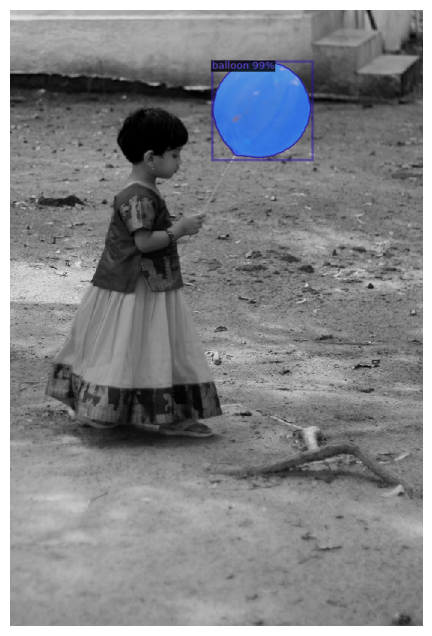

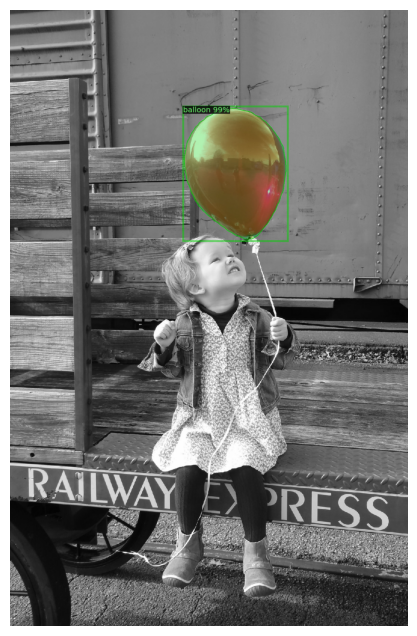


Exercise 2: Half Dataset
Loaded 61 images from /root/Documents/maestria/deep_learning_2025-2/week3/Exercise_3/balloon/train
[09/19 00:42:41 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in


Starting training for 300 iterations...
[09/19 00:42:41 d2.engine.train_loop]: Starting training from iteration 0
[09/19 00:44:39 d2.utils.events]:  eta: 0:29:45  iter: 19  total_loss: 2.182  loss_cls: 0.7672  loss_box_reg: 0.6225  loss_mask: 0.692  loss_rpn_cls: 0.02424  loss_rpn_loc: 0.003763    time: 6.1792  last_time: 5.3108  data_time: 0.0432  last_data_time: 0.0185   lr: 1.6068e-05  max_mem: 5291M
[09/19 00:46:30 d2.utils.events]:  eta: 0:26:48  iter: 39  total_loss: 1.927  loss_cls: 0.6321  loss_box_reg: 0.575  loss_mask: 0.6166  loss_rpn_cls: 0.04248  loss_rpn_loc: 0.008399    time: 6.0331  last_time: 5.7487  data_time: 0.0138  last_data_time: 0.0115   lr: 3.2718e-05  max_mem: 5291M
[09/19 00:48:24 d2.utils.events]:  eta: 0:24:14  iter: 59  total_loss: 1.676  loss_cls: 0.4649  loss_box_reg: 0.6956  loss_mask: 0.4929  loss_rpn_cls: 0.02458  loss_rpn_loc: 0.006555    time: 6.0236  last_time: 5.8518  data_time: 0.0126  last_data_time: 0.0079   lr: 4.9367e-05  max_mem: 5291M
[09/1

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in


Starting training for 300 iterations...
[09/19 01:11:57 d2.engine.train_loop]: Starting training from iteration 0
[09/19 01:13:00 d2.utils.events]:  eta: 0:15:22  iter: 19  total_loss: 1.88  loss_cls: 0.6254  loss_box_reg: 0.5783  loss_mask: 0.6409  loss_rpn_cls: 0.03182  loss_rpn_loc: 0.009373    time: 3.1828  last_time: 3.4230  data_time: 0.0248  last_data_time: 0.0121   lr: 0.00016068  max_mem: 5291M
[09/19 01:14:06 d2.utils.events]:  eta: 0:14:23  iter: 39  total_loss: 1.208  loss_cls: 0.2953  loss_box_reg: 0.5978  loss_mask: 0.2768  loss_rpn_cls: 0.03336  loss_rpn_loc: 0.004962    time: 3.2773  last_time: 3.2610  data_time: 0.0119  last_data_time: 0.0101   lr: 0.00032718  max_mem: 5291M
[09/19 01:15:13 d2.utils.events]:  eta: 0:13:19  iter: 59  total_loss: 1.015  loss_cls: 0.1605  loss_box_reg: 0.597  loss_mask: 0.1428  loss_rpn_cls: 0.02562  loss_rpn_loc: 0.006551    time: 3.3172  last_time: 2.5306  data_time: 0.0129  last_data_time: 0.0196   lr: 0.00049367  max_mem: 5291M
[09/1

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in


Starting training for 1000 iterations...
[09/19 01:27:31 d2.engine.train_loop]: Starting training from iteration 0
[09/19 01:28:05 d2.utils.events]:  eta: 0:27:47  iter: 19  total_loss: 2.037  loss_cls: 0.627  loss_box_reg: 0.6198  loss_mask: 0.697  loss_rpn_cls: 0.03314  loss_rpn_loc: 0.008648    time: 1.6823  last_time: 1.5849  data_time: 0.0239  last_data_time: 0.0118   lr: 4.9953e-06  max_mem: 5291M
[09/19 01:28:40 d2.utils.events]:  eta: 0:27:48  iter: 39  total_loss: 1.875  loss_cls: 0.6034  loss_box_reg: 0.5469  loss_mask: 0.6664  loss_rpn_cls: 0.03668  loss_rpn_loc: 0.004923    time: 1.7130  last_time: 1.5774  data_time: 0.0116  last_data_time: 0.0127   lr: 9.9902e-06  max_mem: 5291M
[09/19 01:29:12 d2.utils.events]:  eta: 0:26:39  iter: 59  total_loss: 1.819  loss_cls: 0.5492  loss_box_reg: 0.6828  loss_mask: 0.6166  loss_rpn_cls: 0.02581  loss_rpn_loc: 0.007381    time: 1.6776  last_time: 1.3874  data_time: 0.0127  last_data_time: 0.0193   lr: 1.4985e-05  max_mem: 5291M
[09/

In [23]:
# Exercise 1: Baseline Model
print("\n" + "="*50)
print("Exercise 1: Baseline Model")
print("="*50)

cfg_baseline = setup_config(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml",
    OUTPUT_DIR / "baseline",
    max_iter=300
)

# Train the model
trainer_baseline, time_baseline = train_model(cfg_baseline)

# Evaluate
metrics_baseline = evaluate_model(trainer_baseline, cfg_baseline)
if 'bbox/AP' in metrics_baseline:
    print(f"\nBaseline mAP: {metrics_baseline['bbox/AP']:.4f}")
else:
    print("\nCould not find bbox/AP. Available metrics:")
    for k, v in metrics_baseline.items():
        if isinstance(v, (int, float)):
            print(f"{k}: {v:.4f}")

# Visualize predictions
print("\nSample predictions from baseline model:")
visualize_predictions(cfg_baseline)

# 11. Exercise 2: Half Dataset
print("\n" + "="*50)
print("Exercise 2: Half Dataset")
print("="*50)

# Create a subset with half the training data
dataset_dicts = DatasetCatalog.get("balloon_train")
half_size = len(dataset_dicts) // 2
DatasetCatalog.pop("balloon_train_half", None)
DatasetCatalog.register("balloon_train_half", lambda: dataset_dicts[:half_size])
MetadataCatalog.get("balloon_train_half").set(thing_classes=["balloon"])

# Configure and train
cfg_half = setup_config(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml",
    OUTPUT_DIR / "half_dataset",
    max_iter=300
)
cfg_half.DATASETS.TRAIN = ("balloon_train_half",)

trainer_half, time_half = train_model(cfg_half)
metrics_half = evaluate_model(trainer_half, cfg_half)

# Print results safely
print("\nHalf dataset results:")
if 'bbox/AP' in metrics_half:
    baseline_map = metrics_baseline.get('bbox/AP', 'N/A') if metrics_baseline else 'N/A'
    print(f"mAP: {metrics_half['bbox/AP']:.4f} (Baseline: {baseline_map})")
else:
    print("Could not find 'bbox/AP' in metrics. Available metrics:")
    for k, v in metrics_half.items():
        if isinstance(v, (int, float)):
            print(f"{k}: {v:.4f}")

# 12. Exercise 3: Higher Learning Rate
print("\n" + "="*50)
print("Exercise 3: Higher Learning Rate")
print("="*50)

cfg_high_lr = setup_config(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml",
    OUTPUT_DIR / "high_lr",
    base_lr=0.0025,  # 10x higher than default
    max_iter=300
)

trainer_high_lr, time_high_lr = train_model(cfg_high_lr)
metrics_high_lr = evaluate_model(trainer_high_lr, cfg_high_lr)
# First print all available metrics to see what we have
print("\nAvailable metrics in metrics_high_lr:", metrics_high_lr.keys())
print("Available metrics in metrics_baseline:", metrics_baseline.keys())

# Then try to find a suitable metric to compare
for metric in ['segm/AP', 'bbox/AP50', 'bbox/AP75', 'AP', 'mAP']:
    if metric in metrics_high_lr and metric in metrics_baseline:
        print(f"\nHigh LR {metric}: {metrics_high_lr[metric]:.4f} (Baseline: {metrics_baseline[metric]:.4f})")
        break
else:
    print("\nCouldn't find standard mAP metrics. Here are all available metrics:")
    print("Baseline metrics:", metrics_baseline)
    print("High LR metrics:", metrics_high_lr)
    
# 13. Exercise 4: More Training Iterations
print("\n" + "="*50)
print("Exercise 4: More Training Iterations")
print("="*50)

cfg_more_iters = setup_config(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml",
    OUTPUT_DIR / "more_iters",
    max_iter=1000  # More iterations
)

trainer_more_iters, time_more_iters = train_model(cfg_more_iters)
metrics_more_iters = evaluate_model(trainer_more_iters, cfg_more_iters)
# Try different possible metric names
for metric in ['segm/AP', 'bbox/AP50', 'bbox/AP75', 'AP', 'mAP']:
    if metric in metrics_more_iters and metric in metrics_baseline:
        print(f"\nMore iters {metric}: {metrics_more_iters[metric]:.4f} (Baseline: {metrics_baseline[metric]:.4f})")
        break
else:
    print("\nCouldn't find standard mAP metrics. Here are all available metrics:")
    print("Baseline metrics:", metrics_baseline)
    print("More iters metrics:", metrics_more_iters)



Exercise 5: Test Different Thresholds

Testing threshold: 0.3
[09/19 00:34:30 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /root/Documents/maestria/deep_learning_2025-2/week3/Exercise_3/output/baseline/model_final.pth ...


/root/miniconda3/envs/dl-gpu/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=to

Loaded 13 images from /root/Documents/maestria/deep_learning_2025-2/week3/Exercise_3/balloon/val


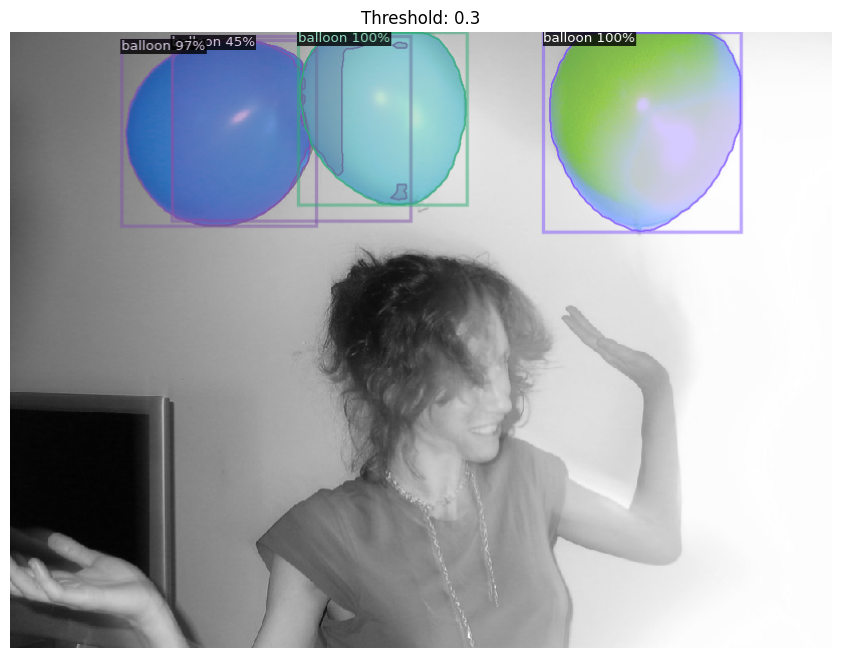


Testing threshold: 0.5
[09/19 00:34:34 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /root/Documents/maestria/deep_learning_2025-2/week3/Exercise_3/output/baseline/model_final.pth ...


/root/miniconda3/envs/dl-gpu/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=to

Loaded 13 images from /root/Documents/maestria/deep_learning_2025-2/week3/Exercise_3/balloon/val


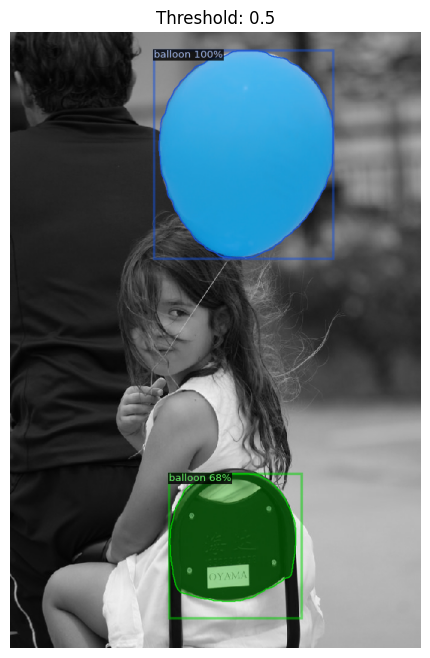


Testing threshold: 0.7
[09/19 00:34:38 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /root/Documents/maestria/deep_learning_2025-2/week3/Exercise_3/output/baseline/model_final.pth ...


/root/miniconda3/envs/dl-gpu/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=to

Loaded 13 images from /root/Documents/maestria/deep_learning_2025-2/week3/Exercise_3/balloon/val


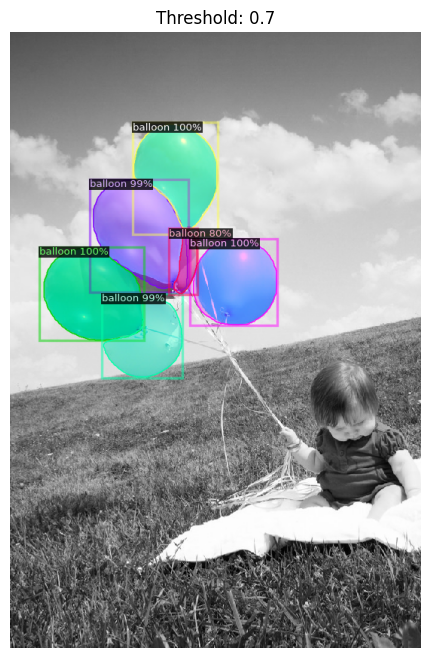


Testing threshold: 0.9
[09/19 00:34:41 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /root/Documents/maestria/deep_learning_2025-2/week3/Exercise_3/output/baseline/model_final.pth ...


/root/miniconda3/envs/dl-gpu/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=to

Loaded 13 images from /root/Documents/maestria/deep_learning_2025-2/week3/Exercise_3/balloon/val


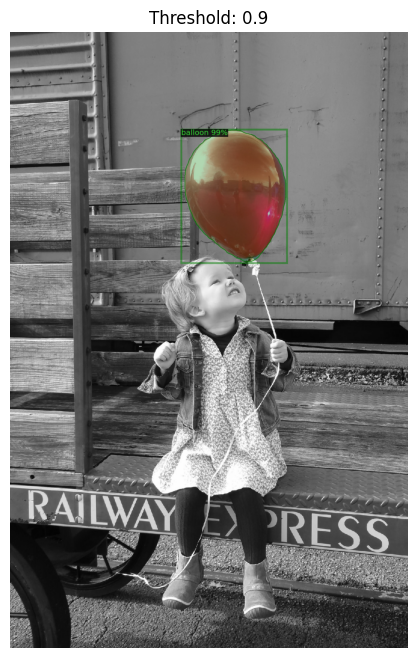


Results Summary
Model                mAP        Time (s)   Params
--------------------------------------------------


KeyError: 'bbox/AP'

In [ ]:
# 14. Exercise 5: Test Different Thresholds
print("\n" + "="*50)
print("Exercise 5: Test Different Thresholds")
print("="*50)

def test_thresholds(cfg, thresholds=[0.3, 0.5, 0.7, 0.9]):
    """Test different confidence thresholds on the baseline model."""
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    if not os.path.exists(cfg.MODEL.WEIGHTS):
        print(f"Error: Model weights not found at {cfg.MODEL.WEIGHTS}")
        return
    
    for threshold in thresholds:
        print(f"\nTesting threshold: {threshold}")
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold
        predictor = DefaultPredictor(cfg)
        
        # Get a sample image
        dataset_dicts = DatasetCatalog.get("balloon_val")
        d = random.choice(dataset_dicts)
        im = cv2.imread(d["file_name"])
        
        if im is None:
            print(f"Warning: Could not read image {d['file_name']}")
            continue
            
        # Make prediction
        outputs = predictor(im)
        
        # Visualize
        v = Visualizer(
            im[:, :, ::-1],
            metadata=MetadataCatalog.get("balloon_val"),
            scale=0.8,
            instance_mode=ColorMode.IMAGE_BW
        )
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        
        plt.figure(figsize=(12, 8))
        plt.imshow(out.get_image()[:, :, ::-1])
        plt.title(f"Threshold: {threshold}")
        plt.axis('off')
        plt.show()

# Test different thresholds on the baseline model
test_thresholds(cfg_baseline)

# 15. Results Summary
def format_results_summary(results):
    """Format the model comparison results in a clean table."""
    # Define column headers and width
    headers = ["Model", "mAP", "Time (s)", "Params"]
    col_width = [20, 10, 10, 10]
    
    # Create the header
    header = "Results Summary".center(50, "=")
    separator = "-" * 50
    
    # Format each row
    rows = []
    for model_name, metrics in results.items():
        row = f"{model_name:<{col_width[0]}} " \
              f"{metrics['mAP']:<{col_width[1]}.4f} " \
              f"{metrics['time']:<{col_width[2]}.1f} " \
              f"{metrics['iters']} iters"
        rows.append(row)
    
    # Combine everything
    formatted = [header]
    formatted.append(" ".join(f"{h:<{w}}" for h, w in zip(headers, col_width)))
    formatted.append(separator)
    formatted.extend(rows)
    
    return "\n".join(formatted)

# Example usage:
results = {
    'Baseline': {'mAP': metrics_baseline['bbox/AP'], 'time': time_baseline, 'iters': 300},
    'Half Dataset': {'mAP': metrics_half['bbox/AP'], 'time': time_half, 'iters': 300},
    'High LR': {'mAP': metrics_high_lr['bbox/AP'], 'time': time_high_lr, 'iters': 300},
    'More Iters': {'mAP': metrics_more_iters['bbox/AP'], 'time': time_more_iters, 'iters': 1000}
}

print(format_results_summary(results))


In [ ]:

# 16. Test with Custom Image
print("\n" + "="*50)
print("Testing with Custom Image")
print("="*50)

def predict_on_custom_image(image_path, cfg, threshold=0.7):
    """Run prediction on a custom image."""
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    if not os.path.exists(cfg.MODEL.WEIGHTS):
        print(f"Error: Model weights not found at {cfg.MODEL.WEIGHTS}")
        return
        
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold
    predictor = DefaultPredictor(cfg)
    
    # Read and predict
    im = cv2.imread(str(image_path))
    if im is None:
        print(f"Error: Could not read image at {image_path}")
        return
    
    outputs = predictor(im)
    
    # Visualize
    v = Visualizer(
        im[:, :, ::-1],
        metadata=MetadataCatalog.get("balloon_val"),
        scale=0.8,
        instance_mode=ColorMode.IMAGE_BW
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    plt.figure(figsize=(12, 8))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()

# Example usage with a test image
test_image_path = BASE_DIR + "/test_images/image1.jpg"
    
if os.path.exists(test_image_path):
    print(f"Testing on custom image: {test_image_path}")
    predict_on_custom_image(test_image_path, cfg_baseline)
else:
    print("Test image not found. Please update the test_image_path variable.")
    print("Trying to use a sample image from the validation set...")
    # Use a sample image from the validation set
    sample_image = next(iter(DatasetCatalog.get("balloon_val")))["file_name"]
    predict_on_custom_image(sample_image, cfg_baseline)

print("\n" + "="*50)
print("Notebook execution completed successfully!")
print("="*50)


Testing with Custom Image


TypeError: unsupported operand type(s) for +: 'PosixPath' and 'str'